In [8]:
import pandas as pd
import numpy as np
import os
import enum
import time
import matplotlib.pyplot as plt
import utils
import json
import seaborn as sns
import ignite

from tqdm.auto import tqdm, trange

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchio as tio
import monai

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import precision_recall_curve

from matplotlib.colors import ListedColormap

from datetime import datetime
from functools import partialmethod

# from google.colab import drive

torch.manual_seed(7)
torch.set_grad_enabled(False)
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

torch.set_grad_enabled(False)
figsize = 16, 9
tio.Subject.plot = partialmethod(tio.Subject.plot, figsize=figsize, reorient=False)

In [9]:
study_path = "../study"

info_df = pd.read_csv(f"{study_path}/stats/info.csv").dropna()

subjects_list = []

for idx, row in info_df.iterrows():
    if "VNSLC" not in row.ID:
        continue
    
    subj_dict = {
        "id": row.ID,
        "resp": row.resp, # Prova cambiando in 0, 0.75, 1
        # "age": row.age,
        # "sex": row.sex,
        # "epilepsy_type": row.epilepsy_type,
        # "epilepsy_onset_age": row.epilepsy_onset_age,
        # "therapy_duration": row.therapy_duration,
        # "AEDs": row.AEDs,
        # "FA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_FA.nii.gz"),
        # "MD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_MD.nii.gz"),
        # "AD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_AD.nii.gz"),
        # "RD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/dti/{row.ID}_RD.nii.gz"),
        # "wFA": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wFA.nii.gz"),
        # "wMD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wMD.nii.gz"),
        # "wAD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wAD.nii.gz"),
        # "wRD": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_wRD.nii.gz"),
        # "diamond_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/diamond/{row.ID}_diamond_frac_csf.nii.gz"),
        # "icvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_icvf.nii.gz"),
        # "odi": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_odi.nii.gz"),
        # "fextra": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fextra.nii.gz"),
        # "fiso": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/noddi/{row.ID}_noddi_fiso.nii.gz"),
        # "wfvf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_wfvf.nii.gz"),
        # "fvf_tot": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_fvf_tot.nii.gz"),
        # "mf_frac_csf": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/dMRI/microstructure/mf/{row.ID}_mf_frac_csf.nii.gz"),
        # "WM_mask": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/White-Matter++.bbr.nii.gz"),
        "aparc_aseg": tio.LabelMap(f"{study_path}/freesurfer/{row.ID}/dlabel/diff/aparc+aseg+thalnuc.bbr.nii.gz"),
        # "tract_prob": tio.ScalarImage(f"{study_path}/freesurfer/{row.ID}/dpath/mergedX2_3D_avg16_syn_bbr.nii.gz"),
        "t1": tio.ScalarImage(f"{study_path}/subjects/{row.ID}/registration/{row.ID}_T1_brain_reg.nii.gz"),
        # "t1": tio.ScalarImage(f"{study_path}/T1/{row.ID}_T1.nii.gz"),
        # "t2_raw": tio.ScalarImage(f"{study_path}/T1/{row.ID}_T2.nii.gz"),
    }

    subjects_list.append(tio.Subject(subj_dict))

In [10]:
root_dir = Path('data')
tio.download.download_and_extract_archive(
    'https://github.com/NifTK/NiftyNetModelZoo/raw/5-reorganising-with-lfs/highres3dnet_brain_parcellation/data.tar.gz',
    root_dir
)
mri_path = list(root_dir.glob('*.nii.gz'))[0]
mri_path

PosixPath('data/OAS1_0145_MR2_mpr_n4_anon_sbj_111.nii.gz')

In [11]:
repo = 'fepegar/highresnet'
model_name = 'highres3dnet'
model = torch.hub.load(repo, model_name, pretrained=True, trust_repo=True)
model.to(device).eval();

Using cache found in /home/cerra/.cache/torch/hub/fepegar_highresnet_master


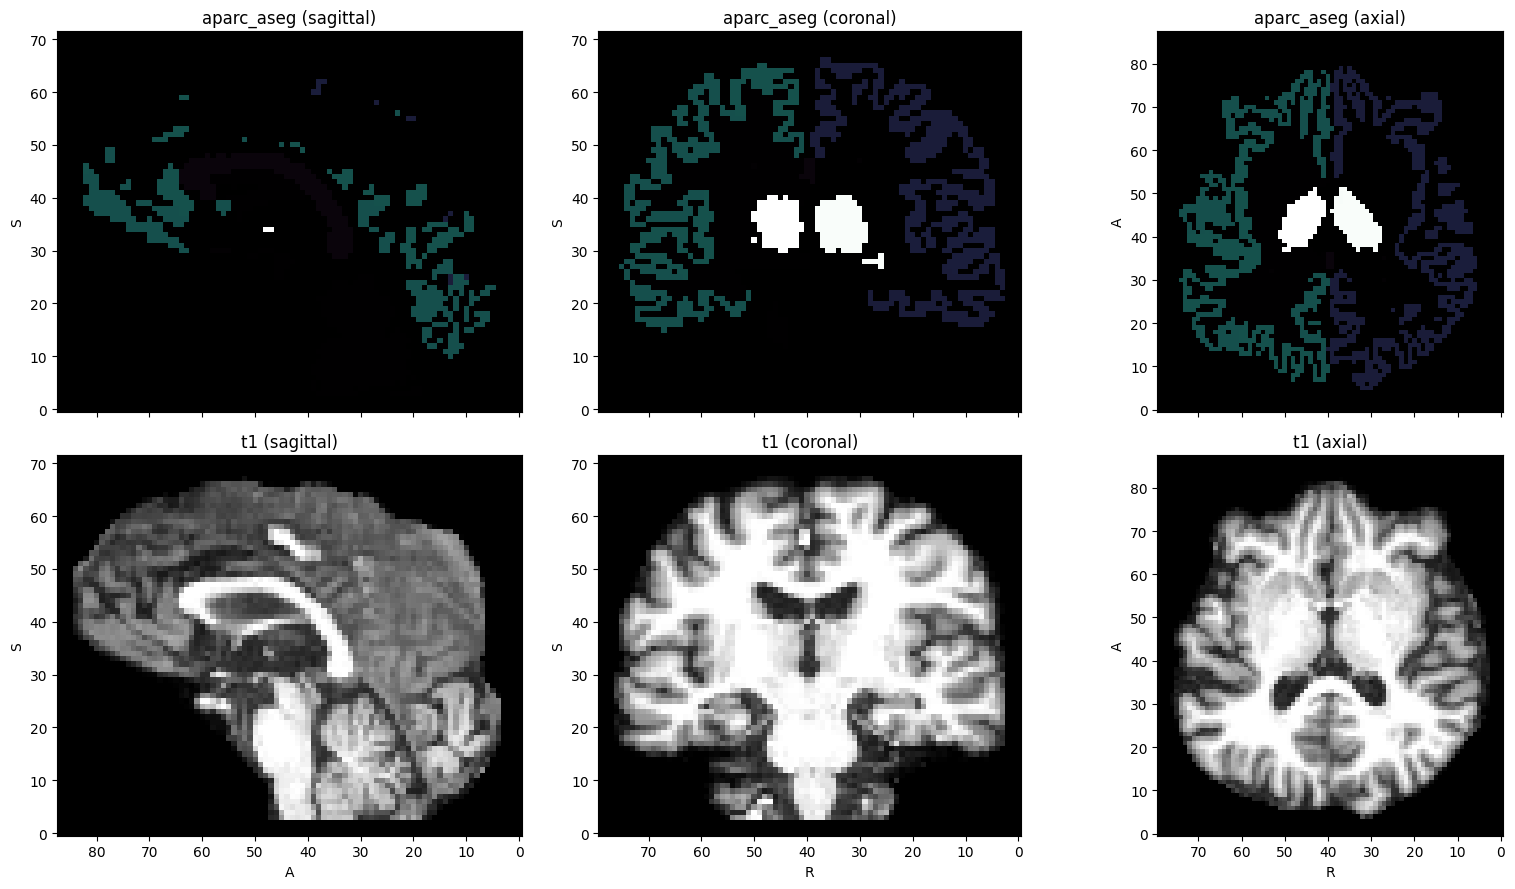

In [13]:
transform = tio.Compose([
    tio.ToCanonical(),
    tio.transforms.Resample("aparc_aseg"),
    tio.transforms.CropOrPad(mask_name="aparc_aseg"),
    tio.transforms.CopyAffine("aparc_aseg"),
    tio.transforms.EnsureShapeMultiple(8, method="pad"),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

preprocessed = transform(subjects_list[0])

preprocessed.plot()

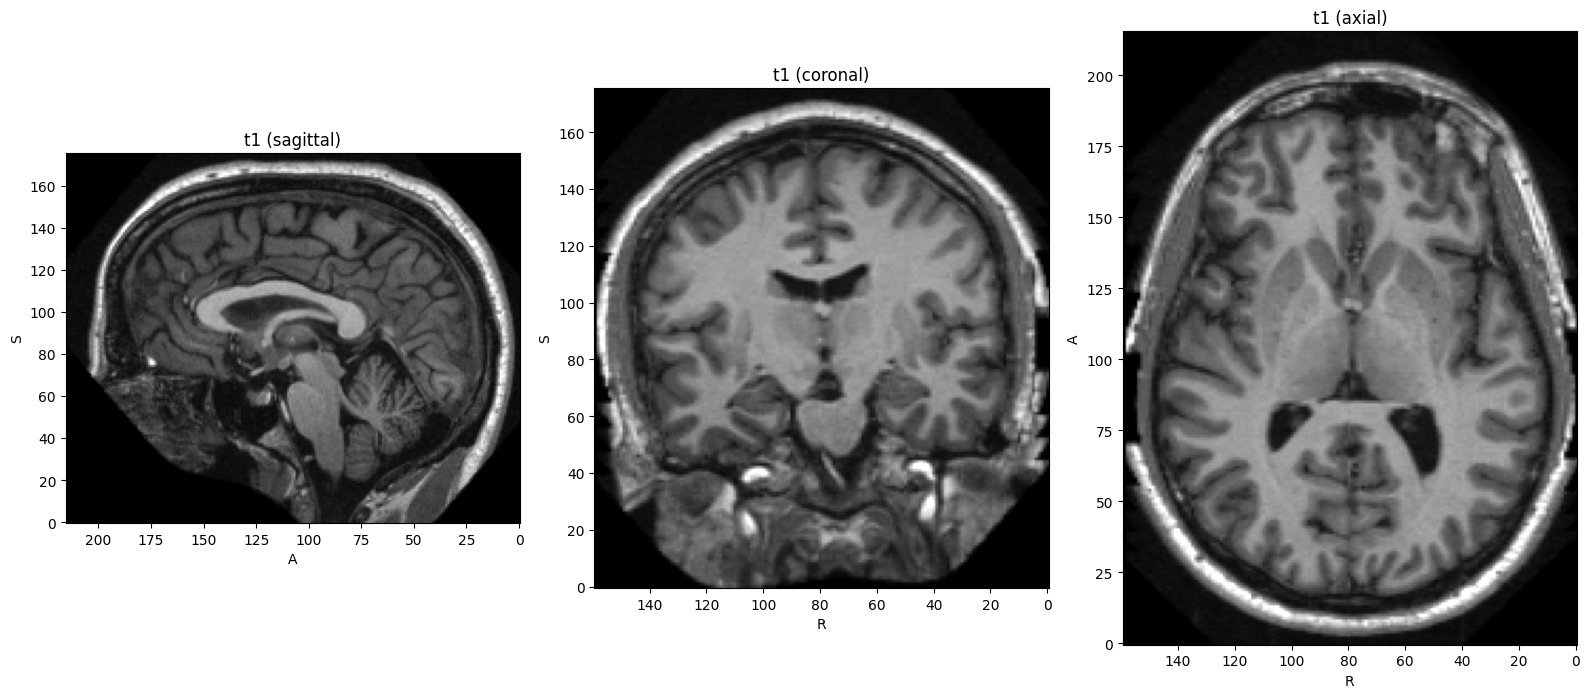

In [47]:
subject_oasis = tio.Subject(t1=tio.ScalarImage(mri_path))
subject = subject_oasis

transforms = [
    tio.ToCanonical(),
    tio.Resample(1),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Crop((0, 0, 10, 30, 40, 40)),
]
transform = tio.Compose(transforms)
preprocessed = transform(subject)

preprocessed.plot()

In [6]:
!curl -sS -O https://raw.githubusercontent.com/fepegar/highresnet/master/GIFNiftyNet.ctbl

In [13]:
class ColorMapHelper:
    def __init__(self, colors_path):
        columns = 'name', *'rgba'
        df = pd.read_csv(colors_path, sep=' ', header=None, index_col=0, names=columns)
        max_index = max(df.index)
        self.cmap_data = np.zeros((max_index + 1, 4))
        df[['r', 'g', 'b', 'a']] = df[['r', 'g', 'b', 'a']] / 255
        self.cmap_data[df.index] = df[['r', 'g', 'b', 'a']].values
        self.cmap_data[:, 3] = 1
        self.cmap = ListedColormap(self.cmap_data)
helper = ColorMapHelper('GIFNiftyNet.ctbl')
cmap = helper.cmap
cmap_dict = {}

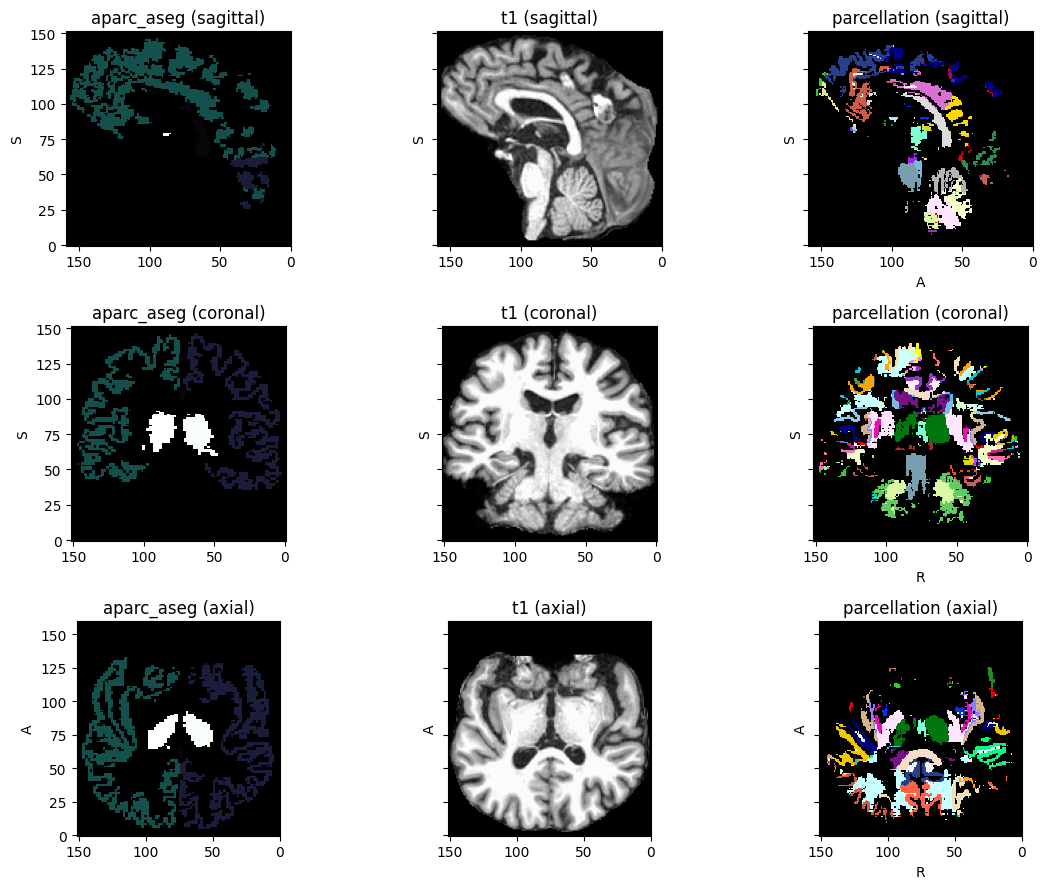

In [14]:
input_tensor = preprocessed["t1"][tio.DATA][np.newaxis].to(device)
with torch.autocast(device.type):
    logits = model(input_tensor)
full_volume_output_tensor = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True).cpu()[0]  # get first along batch dim
seg = tio.LabelMap(tensor=full_volume_output_tensor, affine=preprocessed.t1.affine)
name = 'parcellation'
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
preprocessed.plot(cmap_dict=cmap_dict)

  0%|          | 0/8 [00:00<?, ?batch/s]

/tmp/ipykernel_21782/921395251.py:19: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  patchwise_output_tensor = aggregator.get_output_tensor()


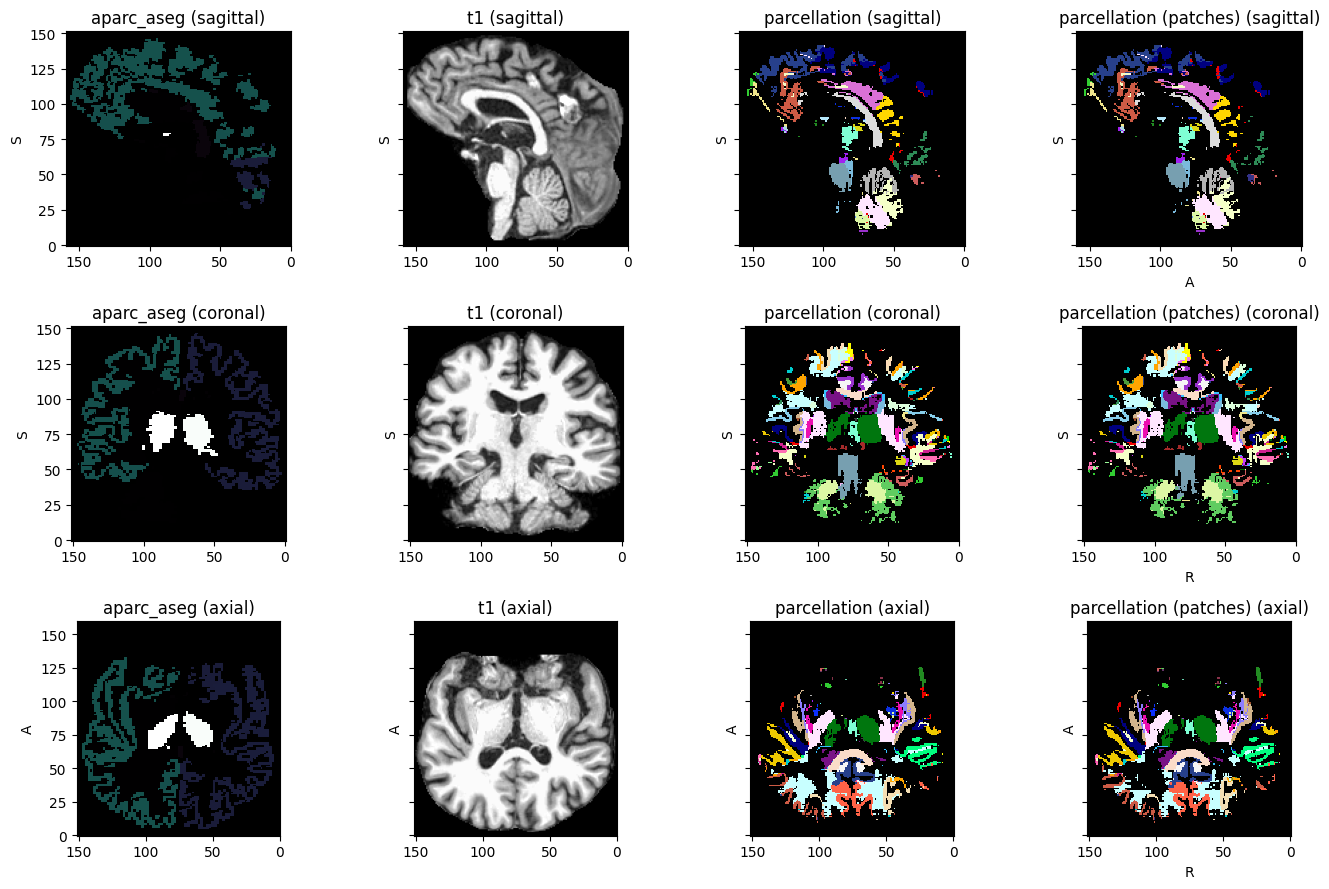

In [15]:
patch_overlap = 4
patch_size = 128
grid_sampler = tio.inference.GridSampler(
    preprocessed,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(grid_sampler)
aggregator = tio.inference.GridAggregator(grid_sampler)
preprocessed.clear_history()  # so that image is not padded when inverting cropping later on

for patches_batch in tqdm(patch_loader, unit='batch'):
    input_tensor = patches_batch['t1'][tio.DATA].to(device)
    locations = patches_batch[tio.LOCATION]
    with torch.autocast(device.type):
        logits = model(input_tensor)
    labels = logits.argmax(dim=tio.CHANNELS_DIMENSION, keepdim=True)
    aggregator.add_batch(labels, locations)
patchwise_output_tensor = aggregator.get_output_tensor()
seg = tio.LabelMap(tensor=patchwise_output_tensor, affine=preprocessed.t1.affine)
name = 'parcellation (patches)'
preprocessed.add_image(seg, name)
cmap_dict[name] = cmap
preprocessed.plot(cmap_dict=cmap_dict)

In [14]:
writer = SummaryWriter('../study/models/run/batch')

writer.add_graph(model, preprocessed["t1"][tio.DATA][np.newaxis].to(device))